## Off-target frequency simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile

from tapqir.models import Cosmos

### Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("ratej"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        
        # calculate ci
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = models[data_path.name].z_marginal.flatten()
        low, high = hpdi(samples, 0.68)
        median = quantile(samples, 0.5)
        fit[data_path.name]["median"] = median.item()
        fit[data_path.name]["low"] = low.item()
        fit[data_path.name]["high"] = high.item()

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df = truth_df.sort_values(by="rate_j")
truth_df

,gain,probs_z,rate_j,proximity,offset,height,background
ratej1,7.0,0.15,0.01,0.2,90.0,3000.0,150.0
ratej5,7.0,0.15,0.05,0.2,90.0,3000.0,150.0
ratej15,7.0,0.15,0.15,0.2,90.0,3000.0,150.0
ratej50,7.0,0.15,0.50,0.2,90.0,3000.0,150.0
ratej100,7.0,0.15,1.00,0.2,90.0,3000.0,150.0


In [5]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df = fit_df.sort_values(by="rate_j").drop(
    ["width_mean_0", "width_size_0", "height_scale", "height"],
    axis=1
)
fit_df

,-ELBO,proximity_0,gain,probs_z_0,probs_z_1,rate_j,MCC,Recall,Precision,FN,TP,TN,FP,median,low,high
ratej1,4812824.0,0.205962,7.008488,0.842994,0.157006,0.008885,0.998461,1.000000,0.997396,0.0,383.0,2116.0,1.0,0.999654,0.999585,0.999724
ratej5,4816298.5,0.208851,7.010008,0.844858,0.155142,0.047991,0.996917,0.997389,0.997389,1.0,382.0,2116.0,1.0,0.999394,0.999222,0.999535
ratej15,4830442.5,0.211684,7.016755,0.846679,0.153321,0.142760,0.987667,0.989556,0.989556,4.0,379.0,2113.0,4.0,0.998818,0.998372,0.999277
ratej50,4892167.5,0.215065,7.026381,0.852242,0.147758,0.506029,0.955080,0.955614,0.968254,17.0,366.0,2105.0,12.0,0.992079,0.989515,0.997309
ratej100,4965197.5,0.209334,7.067310,0.855594,0.144406,0.974947,0.934764,0.934726,0.954667,25.0,358.0,2100.0,17.0,0.985250,0.979129,0.993969


### Figure 2

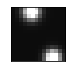

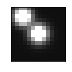

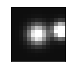

In [6]:
model = models["ratej50"]
n = ontarget = 0
frames = [175, 251, 252]

for f in frames:
    img_ideal = model.data.offset_mean + pyro.param("d/b_loc").data[n, f:f+1, None, None]
    gaussian = model.data_loc(
        pyro.param("d/h_loc").data[:, n, f:f+1].masked_fill(model.m_probs[:, n, f:f+1] < 0.5, 0.),
        pyro.param("d/w_mean").data[:, n, f:f+1],
        pyro.param("d/x_mean").data[:, n, f:f+1],
        pyro.param("d/y_mean").data[:, n, f:f+1],
        n, torch.arange(f,f+1)
    )
    img_ideal = img_ideal + gaussian.sum(-4)
    
    plt.figure(figsize=(1., 1.))
    plt.imshow(img_ideal[0].numpy(), vmin=230, vmax=380, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f"/tmp/theta0.png", dpi=300)
    plt.show()

### Figure 3

In [7]:
model = models["ratej50"]
n = ontarget = 0
frames = [155, 158, 160, 163, 165, 168, 170, 173, 175]
vmin, vmax = model.data.vmin, model.data.vmax

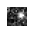

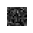

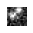

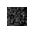

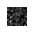

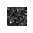

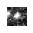

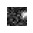

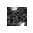

In [8]:
for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    plt.savefig(f"/tmp/simdna{f}.png", dpi=600)
    plt.show()

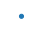

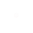

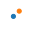

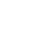

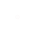

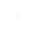

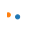

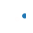

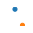

In [9]:
for f in frames:
    fig = plt.figure(figsize=(0.35, 0.35))

    plt.imshow(np.ones((model.data.D, model.data.D)),
               vmin=0, vmax=1, cmap="gray")
    # add patch
    for k in range(2):
        plt.gca().add_patch(
            Circle(
                (model.data.target["y"].iloc[n] + model.data.drift["dy"].iloc[f] +
                 pyro.param("d/y_mean")[k, n, f].item() + 0.5,
                 model.data.target["x"].iloc[n] + model.data.drift["dx"].iloc[f] +
                 pyro.param("d/x_mean")[k, n, f].item() + 0.5),
                1.5, color=f"C{k}", alpha=model.m_probs[k, n, f].item()
            )
        )
    plt.axis("off")
    plt.savefig(f"/tmp/simpoints{f}.png", dpi=600)
    plt.show()

In [10]:
f1, f2 = 155, 176

model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

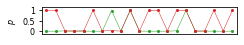

In [11]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[:, n, f1:f2].sum(0),
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)
plt.plot(
    np.arange(f1, f2),
    1 - (1 - model.j_probs[:, n, f1:f2]).prod(0),
    "o-", ms=2, lw=0.5, color="C3", label="off-target"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/ratej-p.svg")
plt.show()

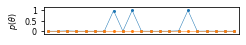

In [12]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$\theta=1$"
)
plt.plot(
    np.arange(f1, f2),
    model.z_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$\theta=2$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\theta)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/ratej-z.svg")
plt.show()

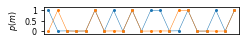

In [13]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.m_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$m_{1}$"
)
plt.plot(
    np.arange(f1, f2),
    model.m_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$m_{2}$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(m)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/ratej-m.svg")
plt.show()

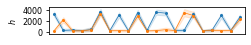

In [14]:
plt.figure(figsize=(3.5,0.5))

hpd = hpdi(trace.nodes["d/height_0"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/height_0"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C0", label="spot 1"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C0"
)
hpd = hpdi(trace.nodes["d/height_1"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/height_1"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C1", label="spot 2"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C1"
)
plt.xticks([])
plt.yticks([0, 2000, 4000], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-500, 4500)
plt.ylabel(r"$h$", fontsize=8)

plt.savefig("/tmp/ratej-h.svg")
plt.show()

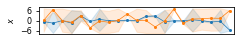

In [15]:
plt.figure(figsize=(3.5,0.5))

hpd = hpdi(trace.nodes["d/x_0"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/x_0"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C0", label="spot 1"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C0"
)
hpd = hpdi(trace.nodes["d/x_1"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/x_1"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C1", label="spot 2"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C1"
)
plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$x$", fontsize=8)

plt.savefig("/tmp/ratej-x.svg")
plt.show()

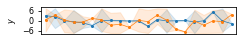

In [16]:
plt.figure(figsize=(3.5,0.5))

hpd = hpdi(trace.nodes["d/y_0"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/y_0"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C0", label="spot 1"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C0"
)
hpd = hpdi(trace.nodes["d/y_1"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/y_1"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C1", label="spot 2"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C1"
)
plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$y$", fontsize=8)

plt.savefig("/tmp/ratej-y.svg")
plt.show()

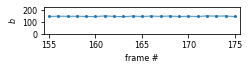

In [17]:
plt.figure(figsize=(3.5,0.5))

hpd = hpdi(trace.nodes["d/background"]["fn"].sample((500,)).data.squeeze(), 0.95, dim=0)
mean = trace.nodes["d/background"]["fn"].mean.data.squeeze()[f1:f2]
plt.plot(
    np.arange(f1, f2),
    mean,
    "o-", ms=2, lw=0.7, color="C0", label="spot 1"
)
plt.fill_between(
    np.arange(f1, f2),
    hpd[0][f1:f2], hpd[1][f1:f2],
    alpha=0.15, color="C0"
)
plt.xticks(np.arange(f1, f2+5, 5), fontsize=8)
plt.yticks([0, 100, 200], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(0, 230)
plt.ylabel(r"$b$", fontsize=8)
#plt.legend(fontsize=8)
plt.xlabel("frame #", fontsize=8)

plt.savefig("/tmp/ratej-b.svg")
plt.show()

### Figure 4

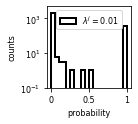

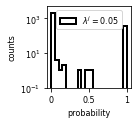

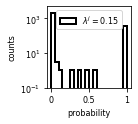

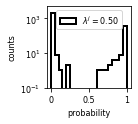

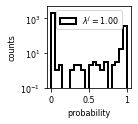

In [30]:
for name in fit_df.index:
    plt.figure(figsize=(1.5, 1.5))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=20, histtype="step", lw=2, color="k",
             label=fr"$\lambda^j=${truth_df.loc[name, 'rate_j']:.2f}")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel("counts", fontsize=8)
    plt.xlabel("probability", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/logdensity-{name}.svg")
    plt.show()

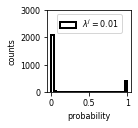

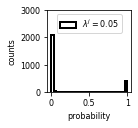

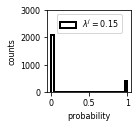

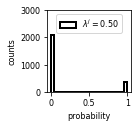

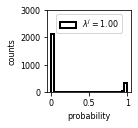

In [29]:
for name in fit_df.index:
    plt.figure(figsize=(1.5, 1.5))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=30, histtype="step", lw=2, color="k",
             label=fr"$\lambda^j=${truth_df.loc[name, 'rate_j']:.2f}")
    plt.xlim(-0.05,1.05)
    plt.ylim(0, 3000)
    plt.xticks([0, 0.5, 1], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel("counts", fontsize=8)
    plt.xlabel("probability", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/density-{name}.svg")
    plt.show()

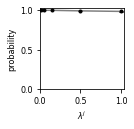

In [21]:
plt.figure(figsize=(1.5, 1.5))
plt.errorbar(truth_df["rate_j"], fit_df["median"],
             yerr=abs(fit_df[["low", "high"]].values.T-fit_df["median"].values),
             fmt="o-", ms=3, color="C7", mfc="k", mec="k", ecolor="k", capsize=2)
plt.xlim(0, 1.03)
plt.ylim(0, 1.03)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$", fontsize=8)
plt.ylabel("probability", fontsize=8)
plt.savefig("/tmp/ratej-errorbar.svg")
plt.show()

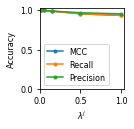

In [22]:
plt.figure(figsize=(1.5, 1.5))
plt.plot(truth_df["rate_j"], fit_df["MCC"], "o-", ms=3, label="MCC")
plt.plot(truth_df["rate_j"], fit_df["Recall"], "o-", ms=3, label="Recall")
plt.plot(truth_df["rate_j"], fit_df["Precision"], "o-", ms=3, label="Precision")
plt.xlim(0, 1.03)
plt.ylim(0, 1.03)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$", fontsize=8)
plt.ylabel("Accuracy", fontsize=8)
plt.legend(fontsize=8)
plt.savefig("/tmp/ratej-mcc.svg")
plt.show()

### Analysis

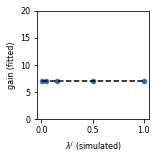

In [28]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel("gain (fitted)", fontsize=8)
plt.show()

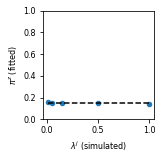

In [27]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\pi^z$ (fitted)", fontsize=8)
plt.show()

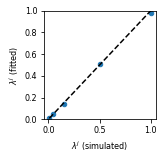

In [25]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\lambda^j$ (fitted)", fontsize=8)
plt.show()

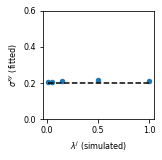

In [26]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["proximity_0"], s=20)
plt.ylim(0., 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fitted)", fontsize=8)
plt.show()